In [1]:
import pickle
import numpy as np
import math
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
methods = ["Difference", "IG", "Mahe", "SI", "STI", "ArchAttribute"]
pcts = [0.1, 0.2, 0.3, 0.4, 0.5]
tag = "6-1"

result_paths = {}
result_paths["Difference"] = "results/segment_auc_difference.pickle"
result_paths["IG"] = "results/segment_auc_ig.pickle"
result_paths["Mahe"] = "results/segment_auc_mahe.pickle"
result_paths["SI"] = "results/segment_auc_si.pickle"
result_paths["STI"] = "results/segment_auc_sti.pickle"
result_paths["ArchAttribute"] =  "results/segment_auc_archattribute.pickle"

In [3]:
method_aucs = {}
for method in methods:
    save_file = result_paths[method]
    with open(save_file, 'rb') as handle:
        b = pickle.load(handle)

    ref = []
    est = {}

    # initially collect results for the loaded pickle file ("b")
    for k in b:
        for key in b[k]["est"]:
            if key not in est:
                est[key] = []

            est[key].extend(b[k]["est"][key])
        ref.extend(b[k]["ref"])

    # process those results
    # this code assumes there is only one method saved per "est" result - modify it if needed
    assert(len(est)==1)
    for key in est:
        f_est = [] 
        f_ref = []

        for i in range(len(est[key])):
            if math.isnan(est[key][i]):
                continue
            f_est.append(est[key][i])
            f_ref.append(ref[i])

        args = np.argsort(f_est)
        
        aucs = []
        for pct in pcts:
            bottom_pct = int(len(f_ref)*pct)+1
            top_pct = len(f_ref) - bottom_pct
            est_sorted = np.array(f_est)[args]
            ref_sorted = np.array(f_ref)[args]
            est_filter = np.concatenate([est_sorted[:bottom_pct] , est_sorted[top_pct:]])
            ref_filter = np.concatenate([ref_sorted[:bottom_pct] , ref_sorted[top_pct:]])

            fpr, tpr, thresholds = metrics.roc_curve(ref_filter, est_filter, pos_label=1)
        
            auc = metrics.auc(fpr, tpr)
            aucs.append(auc)
            
    method_aucs[method] = aucs

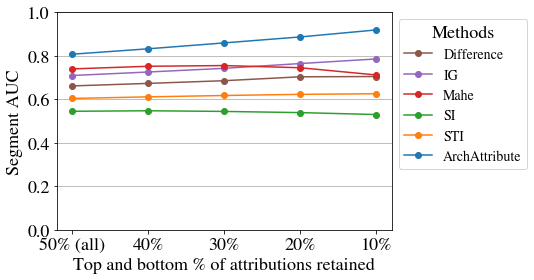

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig= plt.figure()
ax = fig.gca()
for m, method in enumerate(methods):
    if method in method_aucs:
        ax.plot(pcts[::-1], method_aucs[method], marker = 'o', label=method, color=colors[len(methods)-1-m])

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14, title="Methods", title_fontsize=18)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticklabels([0, "50% (all)"  , "40%" ,"30%", "20%", "10%"] , fontsize=18)

plt.ylabel(r"Segment AUC", fontsize=18)
plt.xlabel("Top and bottom % of attributions retained", fontsize=18)

ax.yaxis.grid(True)

plt.savefig("plots/image_sweep_" + tag + ".pdf", bbox_inches="tight")
plt.show()